# Trying to answer the question of why the vectors of the motion fields are so small in magnitude? 
## I think I am not understanding what they represent. 

In [4]:
model_name = "Original_Pretrained_R2plus1D_18_MotionNet.pth"

# model_name = "dropout_v3_0_10_R2plus1D_18_MotionNet.pth"

In [5]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.misc import load_model_by_name

# for finding lv seg borders
import cv2 as cv

# for storing vector snapshots
import copy

# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
# random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.88it/s]


In [6]:
model_save_path = f"save_models/{model_name}"
    
model = load_model_by_name(model_name, model_save_path)

/home/wmw015/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/wmw015/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


gpus detected: 4
using cuda
Original_Pretrained_R2plus1D_18_MotionNet.pth has 31575731 parameters.


In [7]:
from src.strain import *

In [8]:
%matplotlib widget

In [9]:
N = 3
test_pat_index = 0

curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
                                                                                            test_dataset = test_dataset,
                                                                                            test_pat_index = test_pat_index)
    
ed_raw_seg_out = curr_clip_segmentations[:,0,...]

ed_one_hot_seg_out = one_hot(ed_raw_seg_out)

In [10]:
I = ed_one_hot_seg_out
# I = ed_label

I_regional_point_sets = image_to_regional_point_sets(I)

/home/wmw015/summer2022research/echo_22/dev/longitudinal_strain/src/strain.py:1019: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  multichannel=False)
/home/wmw015/summer2022research/echo_22/dev/longitudinal_strain/src/strain.py:1156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  I_regional_point_sets = np.array(I_regional_point_sets)


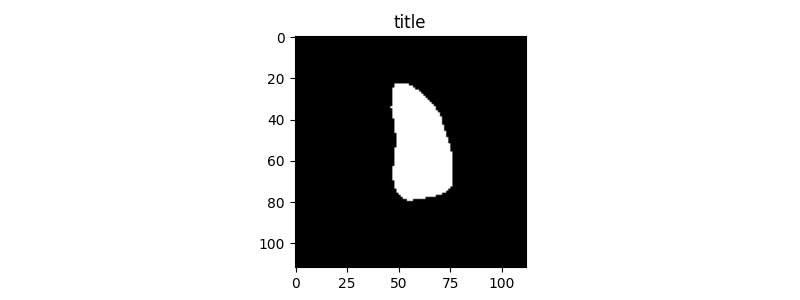

In [11]:
vis_single(I, cmap='gray')

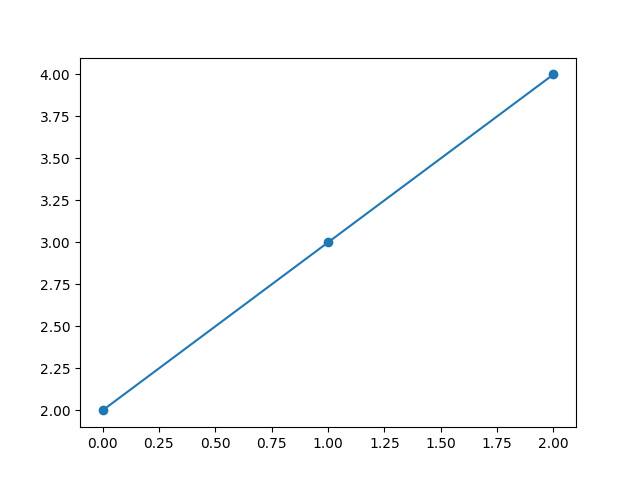

In [12]:
%matplotlib widget

from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot([0,1,2], [2,3,4] ,"o-")

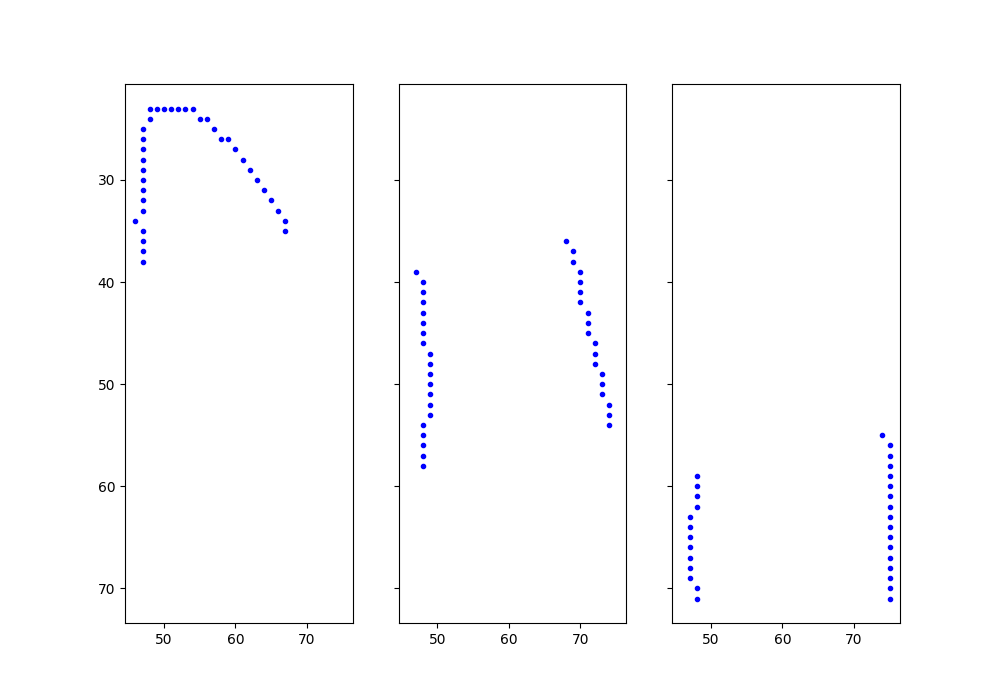

In [13]:
vis_three_point_sets(I_regional_point_sets)

In [14]:
I_regional_point_sets.shape

(3,)

In [15]:
I_regional_point_sets[0].shape

(36, 2)

In [16]:
def vis_single_point_set_from_vectors(ps_vectors):
    ''' ps_vectors - (N, ) np array storing vectors with format (x, y, delta_x, delta_y) '''
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    x = []
    y = []
    for v in ps_vectors:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax.scatter(x, y, marker='.', color='b')
    ax.invert_yaxis()

In [17]:
def vis_single_point_set(ps):
    ''' ps - (N, 2) stored in (x,y)'''
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    ax.scatter(ps[:, 0], ps[:, 1], marker='.', color='b')
    ax.invert_yaxis()

In [18]:
def image_to_whole_point_set(I):
    '''
    I - (112, 112) whole image segmentation
    points - (N, 2) stored in x, y
    '''
    I = give_boundary_no_basal_plane(I)
    points = []
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i][j] == 1:
                points.append(np.array([j, i]))
    return np.array(points)

## break

In [19]:
def convert_point_set_ij_into_xy(ps_ij):
    ''' 
    converts a point set of shape (M, 2) of points in the (i,j) format into 
    point set of shape (M, 2) of points in the (x,y) format where
    x = j
    y = i
    
    input: ps_ij - (M , 2)
    output: ps_xy - (M, 2)
        
    '''
    ps_xy = []
    for point in ps_ij:
        ps_xy.append(np.array([point[1], point[0]]))
    return np.array(ps_xy)

In [20]:
def convert_point_set_xy_into_vectors(ps_xy):
    '''
    converts a single point set passed in of shape (M, 2) into a np array of vector adts of shape (M, ) 
    vectors will have x,y with zero magnitudes representing deltas
    
    assumes the Vector ADT class definition is accessible in global scope
 
    input: ps_xy - (M, 2)
    output: ps_vectors - (M, )
    '''
    ps_vectors = []
    for point in ps_xy:
        ps_vectors.append(Vector(point[0], point[1], 0, 0))
    return np.array(ps_vectors)

In [21]:
apical_point_set = I_regional_point_sets[0]

apical_point_set = convert_point_set_ij_into_xy(apical_point_set)

apical_point_set = convert_point_set_xy_into_vectors(apical_point_set)

In [22]:
previous_apical_point_set = apical_point_set

In [23]:
ijs = []

In [24]:
def warp_one_vector_forward_once(v, frame, motion, scale=1.0):
    '''
    input: 
        v - vector to warp
            should have base values: (x_i, y_j, 0, 0)
        frame - frame integer index
        motion - motion object of shape (4, 32, 112, 112)
    output:
        v_new - vector after warped from given frame
            base values: (x_i+1, y_j+1, 0, 0)
            
    frame given determines what motion tracking information to use
    as the frame integer value will be used to index motion
    '''
    
    global ijs
    new_thing = True    
    
    if new_thing:
        # create the [-1, 1] ranges meshgrids and add them to the raw motion tracking
        grid_w, grid_h = torch.meshgrid([torch.linspace(-1, 1, 112), torch.linspace(-1, 1, 112)])
        # grid_w, grid_h = torch.meshgrid([torch.linspace(0, 0, 112), torch.linspace(0, 0, 112)])
        grid_w = grid_w.numpy()
        grid_h = grid_h.numpy()

        current_frame_motion = motion[:, frame, ...] # reduce shape to be (4, 112, 112)
        forward_x = current_frame_motion[0] # reduce shape to be (112, 112)
        forward_y = current_frame_motion[1] # reduce shape to be (112, 112)
    
        # I am unsure what offset grid to add to with the values of range (-1, 1), bc there are no comments about what's happening
        # I don't know if grid_w should correspond to offsets x or y, 
        # ig i just try and then just choose what works best ?? 
        forward_x += grid_w
        forward_y += grid_h
    
    # get surrounding vectors forming the unit square
    inted_i, inted_j = int(v.tail_y), int(v.tail_x)
    surr_vec_tails = [ [inted_i, inted_j],
                       [inted_i, inted_j+1],
                       [inted_i+1, inted_j],
                       [inted_i+1, inted_j+1] ]
    
    surround_vectors = []

    for _ in surr_vec_tails:
        i,j = _[0], _[1]
        x = j
        y = i
        
        ijs.append((i,j))

        if new_thing:
            f_x = forward_x[i][j]
            f_y = forward_y[i][j]
        else:
            f_x = motion[0][frame][i][j]
            f_y = motion[1][frame][i][j]

        
        surround_vectors.append(Vector(x, y, f_x, f_y))
        
        
    # convert magnitudes into polar, bilinearly interpolate new vector magnitude in polar
    # to the input vector v's tail_x, tail_y, convert back into 
    # cartesian, apply the warp, clear out conversion value holders
    v_new = vector_bilinear_interpolation(vectors=surround_vectors, new_vector=v)
    v_new.update_mag_xy_from_conversion()
    
    v_new.mag_x *= scale
    v_new.mag_y *= scale
    
    v_new.update_tails_from_mags()
    
    v_new.clear_conversion_mags_xy()
    v_new.clear_conversion_mags_rhotheta()
    v_new.clear_magnitudes()
    
    return v_new

In [25]:
def warp_one_vector_forward_delta_times(v, motion, delta, scale=1.0):
    ''' 
    handles warping forward a single vector specifically delta times and returns the new vector 
    
    input:
        v - vector to warp
        motion - motion object of shape (4, 32, 112, 112)
        delta - integer telling us how many times to warp
    '''
    for i in range(delta):
        v = warp_one_vector_forward_once(v, i, motion, scale)
    return v

In [26]:
def warp_one_point_set_forward_delta_times(ps_vectors, motion, delta, scale=1.0):
    '''
    input:
        ps_vectors - (M, )
            input vectors of base values (x_i, y_i, 0, 0)
        motion - motion object of shape (4, 32, 112, 112)
        delta - integer telling us how many times to warp
    output:
        ps_vectors_new - (M, )
            new vectors of base values (x_i+delta, y_i+delta, 0, 0)
                if save_mag flag is False
    '''
    ps_vectors = copy.deepcopy(ps_vectors)
    
    ps_vectors_new = []
    for v in ps_vectors:
        ps_vectors_new.append(warp_one_vector_forward_delta_times(v, motion, delta, scale))
    return np.array(ps_vectors_new)

In [27]:
# new_apical_point_set = warp_one_point_set_forward_delta_times(ps_vectors = apical_point_set, 
#                                        motion = curr_clip_motions,
#                                        delta = delta_ed_es)

## Ok, let's just create the visualization of three regional point sets with ED and ES overlapping

In [28]:
I_ED_and_ES_regional_point_sets_as_vectors = {}
I_ED_and_ES_regional_point_sets_as_vectors['ED'] = []
I_ED_and_ES_regional_point_sets_as_vectors['ES'] = []

In [29]:
# testing
for IND in range(N):
    ps = I_regional_point_sets[IND]

    ps = convert_point_set_ij_into_xy(ps)

    ps = convert_point_set_xy_into_vectors(ps)
    
    for p in ps:
        if (p.tail_x < 0 or p.tail_x > 111) or (p.tail_y < 0 or p.tail_y > 111):
            print(p)

In [30]:
def vis_double_three_point_sets(vectors_dict, title='ED Blue | ES Red'):
    '''
    vectors_dict - two keys 'ED' and 'ES'
        each point to an array of three point sets representing regional points (apical, mid, basal) ... or more depending on N...well it's hardcoded for now
    '''
    fig, ax = plt.subplots(1,3, figsize=(10,7), sharex = True, sharey = True)
    x = []
    y = []
    for v in vectors_dict['ED'][0]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[0].scatter(x, y, marker='.', color='b', zorder=1)     # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][0]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[0].scatter(x, y, marker='.', color='r', zorder=2) # ES
    ax[0].invert_yaxis()
    ax[0].set_title('Apical')

    
    x.clear()
    y.clear()
    for v in vectors_dict['ED'][1]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[1].scatter(x, y, marker='.', color='b', zorder=1)    # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][1]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[1].scatter(x, y, marker='.', color='r', zorder=2)# ES
    ax[1].invert_yaxis()
    ax[1].set_title('Mid')

    
    x.clear()
    y.clear()
    for v in vectors_dict['ED'][2]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[2].scatter(x, y, marker='.', color='b', zorder=1)    # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][2]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[2].scatter(x, y, marker='.', color='r', zorder=2)# ES
    ax[2].invert_yaxis()
    ax[2].set_title('Basal')
    
    fig.suptitle(title)

In [31]:
# vis_double_three_point_sets(vectors_dict = I_ED_and_ES_regional_point_sets_as_vectors)

## Compare that using model's ED segmentation output with the point sets gotten directly from the Dataset labels

In [32]:
ground_truth_I_ED_and_ES_regional_point_sets_as_vectors = {}
ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ED'] = []
ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ES'] = []

ed_regional_point_sets = image_to_regional_point_sets(ed_label)
es_regional_point_sets = image_to_regional_point_sets(es_label)

for IND in range(N):
    ed_ps = ed_regional_point_sets[IND]
    ed_ps = convert_point_set_ij_into_xy(ed_ps)
    ed_ps = convert_point_set_xy_into_vectors(ed_ps)
    
    es_ps = es_regional_point_sets[IND]
    es_ps = convert_point_set_ij_into_xy(es_ps)
    es_ps = convert_point_set_xy_into_vectors(es_ps)

    
    ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ED'].append(ed_ps)
    ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ES'].append(es_ps)

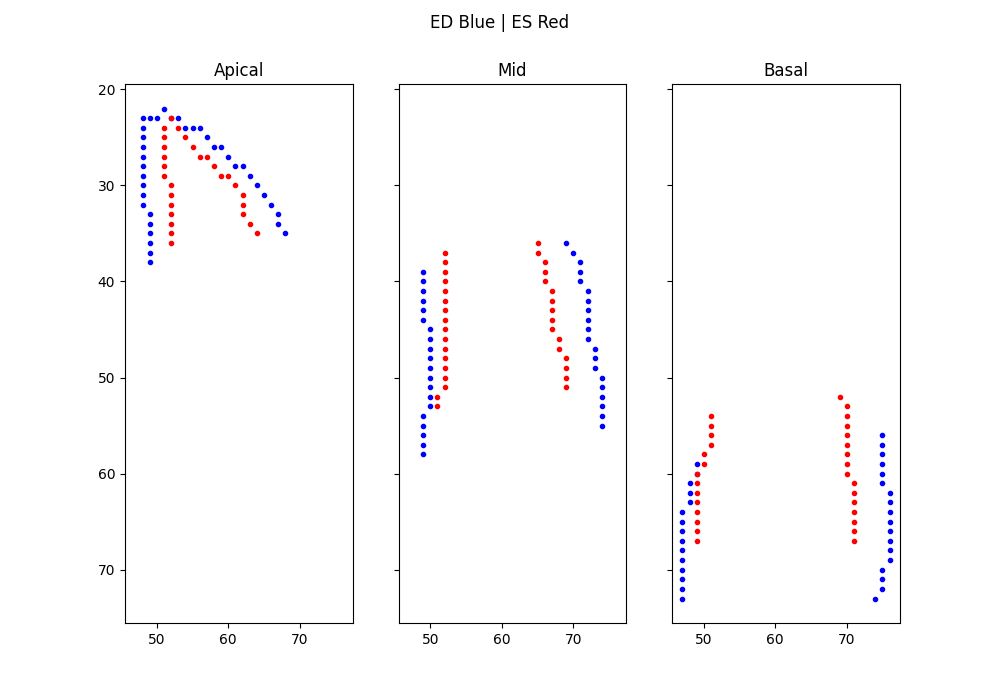

In [33]:
vis_double_three_point_sets(vectors_dict = ground_truth_I_ED_and_ES_regional_point_sets_as_vectors)

## Let's try scaling the magnitudes of the vectors and see if we get better movement? But I wouldn't think so??

In [36]:
I_ED_and_ES_regional_point_sets_as_vectors_1 = {}
I_ED_and_ES_regional_point_sets_as_vectors_1['ED'] = []
I_ED_and_ES_regional_point_sets_as_vectors_1['ES'] = []


for IND in range(N):
    ps = I_regional_point_sets[IND]

    ps = convert_point_set_ij_into_xy(ps)

    ps = convert_point_set_xy_into_vectors(ps)

    new_ps = warp_one_point_set_forward_delta_times(ps_vectors = ps,
                                           motion = curr_clip_motions,
                                           delta = delta_ed_es,
                                           scale = 1)

    I_ED_and_ES_regional_point_sets_as_vectors_1['ED'].append(ps)
    I_ED_and_ES_regional_point_sets_as_vectors_1['ES'].append(new_ps)

IndexError: index 112 is out of bounds for axis 0 with size 112

In [35]:
np.sum([len(I_ED_and_ES_regional_point_sets_as_vectors_1['ED'][i]) for i in range(3)]) * 5

IndexError: list index out of range

In [37]:
ijs_arr = np.array(ijs)

In [38]:
ijs_arr.shape

(1579, 2)

In [39]:
(1,2) == (1,2)

True

In [40]:
(1,2) == (1,3)

False

In [41]:
# for i,x in enumerate(ijs):
#     print(i, x)

In [42]:
ijs[8]

(22, 46)

In [43]:
ijs[12]

(22, 46)

In [44]:
ijs[8] == ijs[12]

True

In [45]:
count = 0
blah = []
for x in ijs:
    if x not in blah:
        blah.append(x)
    else:
        count += 1
count

632

In [46]:
len(ijs)

1579

In [47]:
len(ijs) - count

947

In [48]:
count / len(ijs)

0.40025332488917037

In [49]:
np.unique(ijs_arr, 1)

(array([-118,  -95,  -94,  -76,  -75,  -61,  -60,  -58,  -57,  -56,  -53,
         -52,  -51,  -50,  -49,  -48,  -47,  -46,  -45,  -44,  -43,  -42,
         -41,  -40,  -39,  -38,  -37,  -36,  -35,  -34,  -33,  -32,  -31,
         -30,  -29,  -28,  -27,  -26,  -25,  -24,  -23,  -22,  -21,  -20,
         -19,  -18,  -17,  -16,  -15,  -14,  -13,  -12,  -11,  -10,   -9,
          -8,   -7,   -6,   -5,   -4,   -3,   -2,   -1,    0,    1,    2,
           3,    4,    5,    6,    7,    8,    9,   10,   11,   12,   13,
          14,   15,   16,   17,   18,   19,   20,   21,   22,   23,   24,
          25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,
          47,   48,   49,   50,   51,   52,   53,   54,   55,   56,   57,
          58,   59,   60,   61,   62,   63,   64,   65,   66,   67,   68,
          69,   72,   73,   77,   78,   81,   82,   87,   88,   94,   95,
         111,  112]),
 array([3040, 30

IndexError: list index out of range

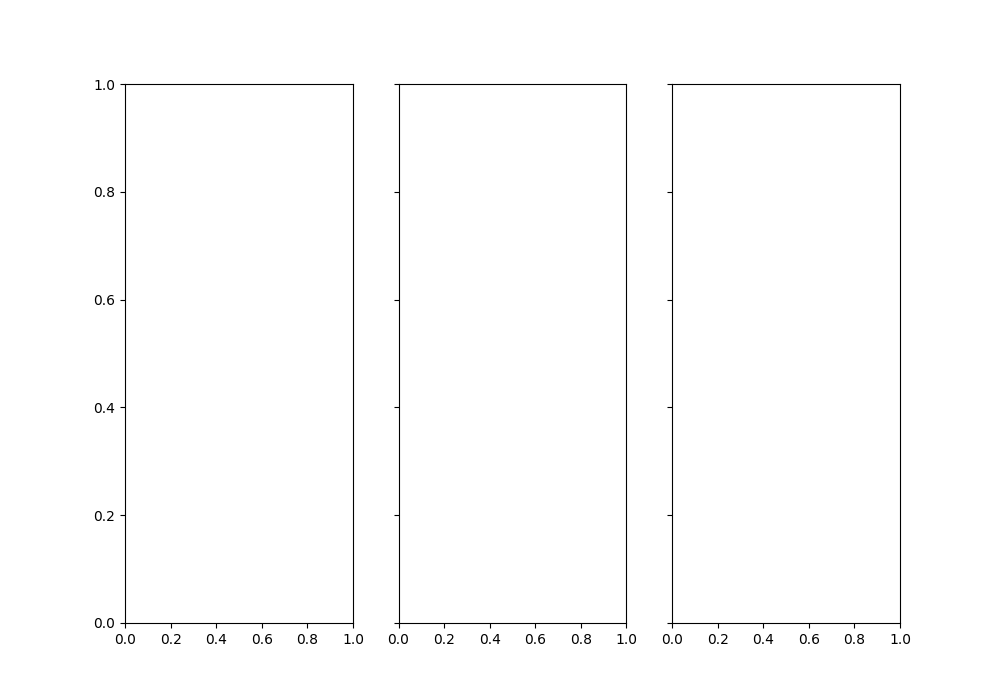

In [50]:
vis_double_three_point_sets(vectors_dict = I_ED_and_ES_regional_point_sets_as_vectors_1)

In [ ]:
curr_clip_motions.shape

### From debugging, learned that motion tracking info was modified before being used to sample a new "grid" by adding the values after passed thru the tanh activation function to a matrix of values created from the range of -1 to 1 for 112 steps

In [51]:
frame = 0


# create the [-1, 1] ranges meshgrids and add them to the raw motion tracking
grid_w, grid_h = torch.meshgrid([torch.linspace(-1, 1, 112), torch.linspace(-1, 1, 112)])
# grid_w, grid_h = torch.meshgrid([torch.linspace(0, 0, 112), torch.linspace(0, 0, 112)])
grid_w = grid_w.numpy()
grid_h = grid_h.numpy()

current_frame_motion = curr_clip_motions[:, frame, ...] # reduce shape to be (4, 112, 112)
forward_x = current_frame_motion[0] # reduce shape to be (112, 112)
forward_y = current_frame_motion[1] # reduce shape to be (112, 112)

In [52]:
curr_clip_motions.shape

(4, 32, 112, 112)

In [53]:
curr_clip_motions[0][0]

array([[-25.14688303, -25.15984605, -25.17191456, ..., -24.89691421,
        -24.91213945, -24.92344259],
       [-24.69812159, -24.71097395, -24.72389644, ..., -24.44819126,
        -24.46318542, -24.47440723],
       [-24.25011045, -24.2624906 , -24.27533643, ..., -23.99962041,
        -24.01414727, -24.02559362],
       ...,
       [ 24.06273882,  24.07044383,  24.07427751, ...,  24.31608304,
         24.30938277,  24.30300999],
       [ 24.50430846,  24.51442928,  24.52097541, ...,  24.76080614,
         24.76037486,  24.7607079 ],
       [ 24.939722  ,  24.95175482,  24.96153394, ...,  25.20673296,
         25.21303818,  25.22357385]])

In [54]:
forward_x

array([[-25.14688303, -25.15984605, -25.17191456, ..., -24.89691421,
        -24.91213945, -24.92344259],
       [-24.69812159, -24.71097395, -24.72389644, ..., -24.44819126,
        -24.46318542, -24.47440723],
       [-24.25011045, -24.2624906 , -24.27533643, ..., -23.99962041,
        -24.01414727, -24.02559362],
       ...,
       [ 24.06273882,  24.07044383,  24.07427751, ...,  24.31608304,
         24.30938277,  24.30300999],
       [ 24.50430846,  24.51442928,  24.52097541, ...,  24.76080614,
         24.76037486,  24.7607079 ],
       [ 24.939722  ,  24.95175482,  24.96153394, ...,  25.20673296,
         25.21303818,  25.22357385]])

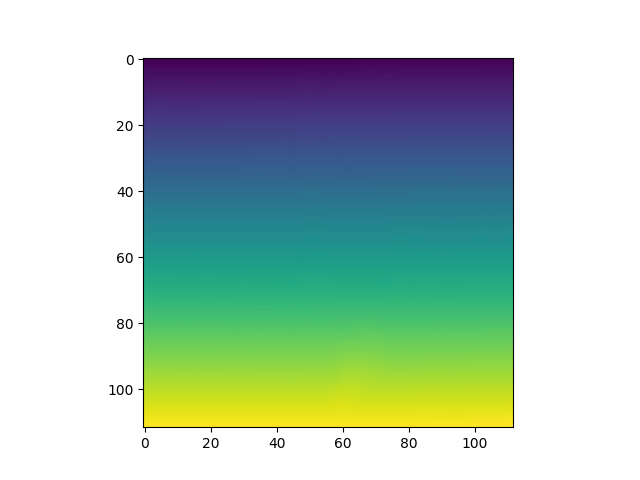

In [55]:
plt.figure()
plt.imshow(forward_x)

In [56]:
grid_w

array([[-1.      , -1.      , -1.      , ..., -1.      , -1.      ,
        -1.      ],
       [-0.981982, -0.981982, -0.981982, ..., -0.981982, -0.981982,
        -0.981982],
       [-0.963964, -0.963964, -0.963964, ..., -0.963964, -0.963964,
        -0.963964],
       ...,
       [ 0.963964,  0.963964,  0.963964, ...,  0.963964,  0.963964,
         0.963964],
       [ 0.981982,  0.981982,  0.981982, ...,  0.981982,  0.981982,
         0.981982],
       [ 1.      ,  1.      ,  1.      , ...,  1.      ,  1.      ,
         1.      ]], dtype=float32)

In [57]:
grid_h

array([[-1.      , -0.981982, -0.963964, ...,  0.963964,  0.981982,
         1.      ],
       [-1.      , -0.981982, -0.963964, ...,  0.963964,  0.981982,
         1.      ],
       [-1.      , -0.981982, -0.963964, ...,  0.963964,  0.981982,
         1.      ],
       ...,
       [-1.      , -0.981982, -0.963964, ...,  0.963964,  0.981982,
         1.      ],
       [-1.      , -0.981982, -0.963964, ...,  0.963964,  0.981982,
         1.      ],
       [-1.      , -0.981982, -0.963964, ...,  0.963964,  0.981982,
         1.      ]], dtype=float32)

In [58]:
forward_x.shape

(112, 112)

In [59]:
forward_x += grid_w
forward_y += grid_h

In [60]:
forward_x

array([[-26.14688303, -26.15984605, -26.17191456, ..., -25.89691421,
        -25.91213945, -25.92344259],
       [-25.68010359, -25.69295594, -25.70587844, ..., -25.43017326,
        -25.44516741, -25.45638922],
       [-25.21407443, -25.22645459, -25.23930041, ..., -24.96358439,
        -24.97811125, -24.98955761],
       ...,
       [ 25.02670281,  25.03440782,  25.03824149, ...,  25.28004703,
         25.27334675,  25.26697397],
       [ 25.48629045,  25.49641128,  25.50295741, ...,  25.74278814,
         25.74235685,  25.74268989],
       [ 25.939722  ,  25.95175482,  25.96153394, ...,  26.20673296,
         26.21303818,  26.22357385]])

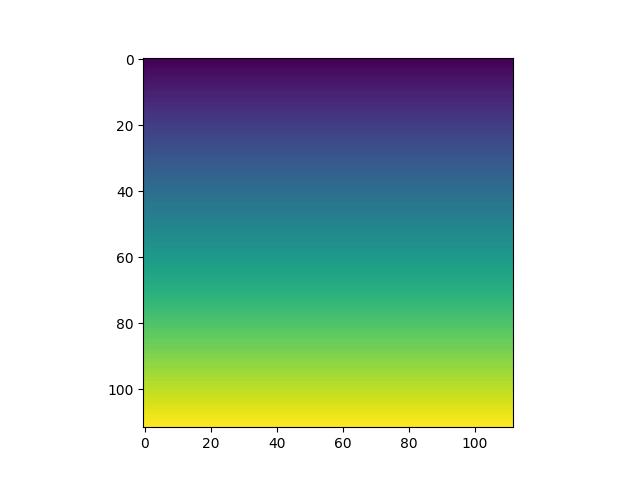

In [61]:
plt.figure()
plt.imshow(grid_w)

Now use this to move the points forward? 

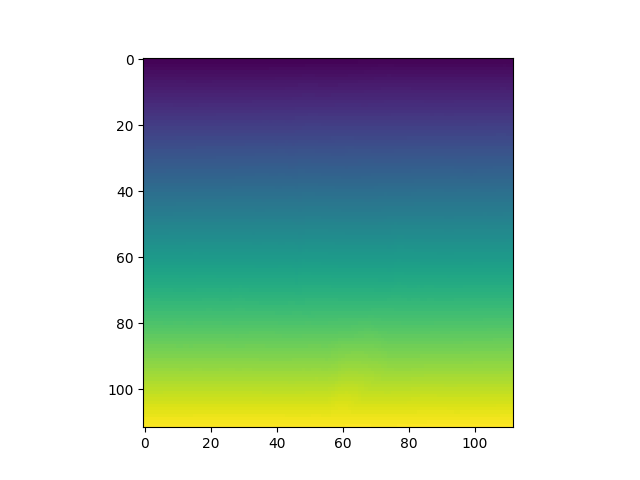

In [62]:
plt.figure()
plt.imshow(forward_x)

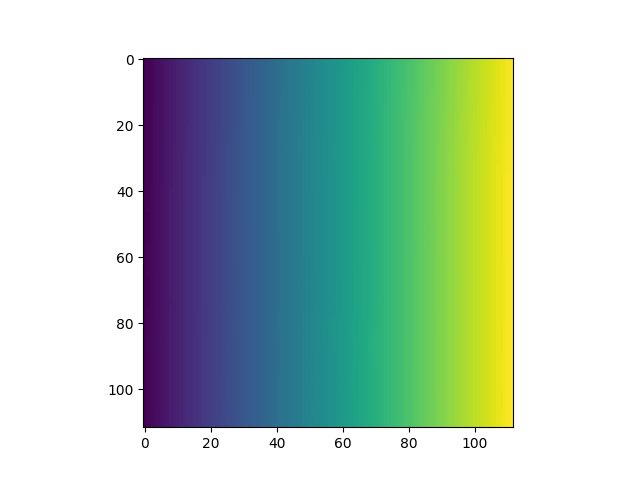

In [63]:
plt.figure()
plt.imshow(forward_y)